In [1]:
write = False # log this version as new
MODEL_DESCRIPTION = "Stratified Learning"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMaker import *

2023-07-31 10:46:59.893656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 10:47:00.375931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 256
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 64, 64)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-3

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-31 10:47:01.945083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 10:47:01.964483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 10:47:01.964688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "CVAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/CVAE/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_training.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_testing.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_validation.hdf5', **args_gen)

In [8]:
n = BATCH_SIZE
l = len(train_gen._indices)

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
concat = tf.keras.layers.Concatenate()([flatten, redshifts])
dense1 = Dense(512, activation = "relu")(concat)
dense2 = Dense(512, activation = "relu")(dense1)
dense3 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(dense2)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense3)
encoder = Model([images, redshifts], z)

In [10]:
zc = Input(shape = (LATENT_DIM + 1, ))
dense4 = Dense(512, activation = "relu")(zc)
dense5 = Dense(512, activation = "relu")(dense4) # Size of the dense layer changed
dense6 = Dense(64 * 16 * 16, activation = "relu")(dense5) # Size of the dense layer changed
reshape = Reshape((64, 16, 16))(dense6) # Reshape size changed
conv3 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape)
conv4 = Conv2DTranspose(5, 3, strides = 2, activation = "sigmoid", padding = 'same', data_format = 'channels_first')(conv3)
outputs = Reshape(IMAGE_SHAPE)(conv4)
decoder = Model(zc, outputs)

In [11]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs=[images, redshifts], outputs=decoder_output)

In [12]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 64, 64)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 16, 16)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                              

In [17]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [20]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

def scheduler(epoch, lr):
    if epoch <= 100:
        return lr
    else:
        return lr / 10

LR_modify_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-162


In [21]:
history = model.fit(train_gen, epochs = 500, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/500
  1/368 [..............................] - ETA: 42s - loss: 13.5034

2023-07-31 23:31:25.655417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


368/368 [==============================] - 33s 89ms/step - loss: 9.2447 - val_loss: 9.3909 - lr: 0.0010
Epoch 2/500
368/368 [==============================] - 33s 89ms/step - loss: 9.2431 - val_loss: 9.3911 - lr: 0.0010
Epoch 3/500
368/368 [==============================] - 33s 90ms/step - loss: 9.2429 - val_loss: 9.3914 - lr: 0.0010
Epoch 4/500
 53/368 [===>..........................] - ETA: 23s - loss: 8.4681

KeyboardInterrupt: 

In [16]:
model.save_weights(weights_path)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/data3/Billy/models/HSC_v6_CVAE_v1.0/v1.0.20230731_10_47_02/model/data3/Billy/CVAE/weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
model.load_weights(weights_path)

z = 0.895431221


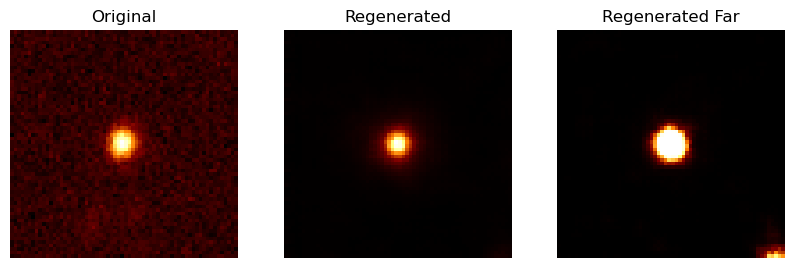

In [29]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 4
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 0.729200006


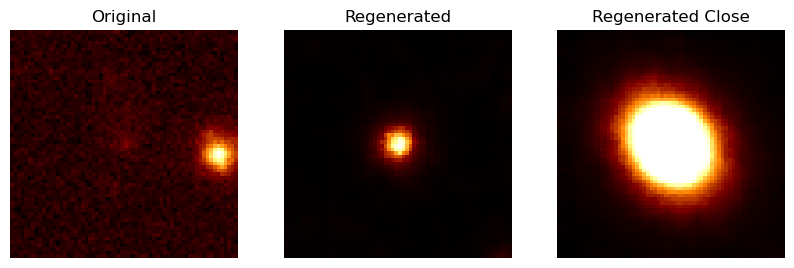

In [32]:
lib = 5
index = 271
z = test_gen[lib][0][1][index]
z_shifted = 0.1
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

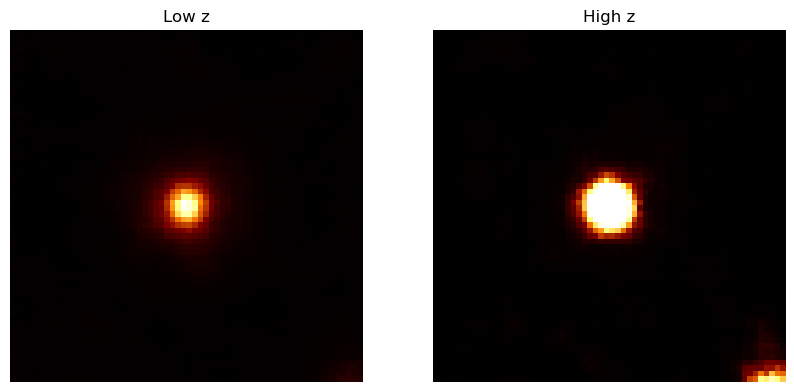

In [28]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([4])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, decoder([strlo])[0][j][63][63])
    hi_array = np.append(hi_array, decoder([strhi])[0][j][63][63])
axes[0].scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes[1].scatter(x_array, hi_array, c = 'red', label = 'High')
axes[0].set_xlabel("Bands")
axes[0].set_ylabel("Central Pixel Value")
axes[0].legend()
axes[1].legend()

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, np.amax(np.transpose(np.asarray(decoder([strlo])[0][j][60:67]))[60:67].flatten()))
    hi_array = np.append(hi_array, np.amax(np.transpose(np.asarray(decoder([strhi])[0][j][60:67]))[60:67].flatten()))
axes.scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes.scatter(x_array, hi_array, c = 'red', label = 'High')
axes.set_xlabel("Bands")
axes.set_ylabel("Max Pixel Value Near Center")
axes.legend()
axes.legend()

In [ ]:
for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] <= 0.1:
            print(j)
            print(i)

In [ ]:
for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] >= 3.5:
            print(j)
            print(i)

In [ ]:
for i in range(0, 84):
    l = 512
    if i == 83:
        l = 464
    for j in range(0, l):
        index = i * BATCH_SIZE + j + 1
        stdout.write("\rChecking %d samples of " % (index) + "42960")
        z = test_gen[i][0][1][j]
        str = np.asarray(encoder([np.array([test_gen[i][0][0][j]]), np.array([test_gen[i][0][1][j]])])[0])
        str = np.concatenate((str, np.array([z])))
        str = str.reshape(1, LATENT_DIM + 1)
        hdul = fits.PrimaryHDU(data = test_gen[i][0][0][j])
        string = f"/data/CVAE Generated/Full/Original Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)
        hdul = fits.PrimaryHDU(data = decoder([str])[0])
        string = f"/data/CVAE Generated/Full/Reconstructed Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)

In [ ]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

In [ ]:
scatter_bands_max_near_center(num_to_show = 10, index = 10)

In [ ]:
x_array = np.array([])
y_array = np.array([])
l = len(test_gen[0][0][0])
print(l)
for i in range(0, l):
    x_array = np.append(x_array, np.amax(np.array([test_gen[0][0][0][i][4]])))
    y_array = np.append(y_array, np.array([test_gen[0][0][1][i]])[0])
    print(i)
plt.scatter(y_array, x_array)

In [ ]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_array, x_array])).astype('float32')
z = gaussian_kde(xy)(xy)
plt.scatter(y_array, x_array, s = 5, c = z)
plt.xlim(0,4)
plt.ylim(0, 80)
plt.xlabel("z")
plt.ylabel("Maximum Pixel Value near the Center")
plt.show()

In [ ]:
scatter_bands_center_shift(lib = 3, i = 267, z = 40)

In [ ]:
scatter_bands_max_shift(lib = 3, i = 37, z = test_gen[3][0][1][37])

In [ ]:
scatter_bands_max_shift(lib = 3, i = 37, z = 0.1)

In [ ]:
scatter_bands_max()

In [ ]:
scatter_bands_center()

In [ ]:
scatter_bands_mean(10, 0)

In [ ]:
scatter_bands_percentile()

In [ ]:
# display_histograms()

In [ ]:
display_5_bands(38)

In [ ]:
display_high_loss(10, 1)

In [34]:
from tqdm import tqdm

In [36]:
hf = h5py.File('/data3/Billy/64x64_cvae_generated_4.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(1999)):
    z = random.uniform(0,4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 1999/1999 [00:45<00:00, 43.86it/s]


Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-162/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-161/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-160/metadata


In [ ]:
# END